# Final Capstone Project:
## Singapore Sign (SgSL) Language Recognition through Computer Vision

---
# Notebook 02 - Contents

**[1. Imports](#1.-Imports)**<br>

**[2. Data Augmentation](#2.-Data-Augmentation)**<br>
[2.1 Inspect Pixel Intensity (Brightness) for Augmented train Dataset](#2.1-Inspect-Pixel-Intensity-(Brightness)-for-Augmented-train-Dataset)<br>
[2.2 Visualizing Data Augmentation](#2.2-Visualizing-Data-Augmentation)<br>

**[3. Modelling - Image Classification](#3.-Modelling---Image-Classification)**<br>
[3.0 Create Relevant Functions](#3.0-Create-Relevant-Functions)<br>
[3.1 VGG16](#3.1-VGG16)<br>
[3.2 InceptionV3](#3.2-InceptionV3)<br>
[3.3 MobileNetV2](#3.3-MobileNetV2)<br>
[3.4 EfficientNetB0](#3.4-EfficientNetB0)<br>

**[4. Best Model Selection](#4.-Best-Model-Selection)**<br>

**[5. Model Interpretation](#5.-Model-Interpretation)**<br>
[5.1 Make predictions using Best Model](#5.1-Make-predictions-using-Best-Model)<br>

---
# Recap - Problem Statement

* In light of the above context, you have been engaged by Instagram, who seeks to advocate for improved inclusivity by enabling HOH community to create and share content equally effortlessly. Instagram is keen to build upon their existing framework of real-time voice-based caption generation - through the development of a new feature enabling automatic generation of text subtitles from live video signing. This would contribute to many use-case scenarios within Social Media and Communication Technology such as instagram reels functions, real-time captions during video calls, etc.

* To address this challenge, your objective is to explore a series of computer vision deep learning models that can perform recognition of Singapore Sign Language (SgSL).

### Capstone Focus
* As a Proof-of-Concept (POC), the focus of this capstone is on `PART 1 - ALPHABET CLASSIFICATION`. <br>The aim is To experiment with several deep learning methods for sign recognition at the alphabet level
    * `Notebook 1:` Problem Statement, Exploratory Data Analysis (EDA)
    * `Notebook 2:` Explore various transfer learning models to find the optimal image classification model that can effectively classify the 26 SGSL signs for letters in the alphabet.
    * `Notebook 3:` Explore object detection through YOLOv8, a state-of-the-art (SOTA) model
 
---

# Modelling - Image Classification

In this notebook 01, we will be exploring image classification.
* First, we will carry out image classification, meaning to predict the class of an object in an image. The input will be an image with a single object (a photograph with a handsign), while output will be the class label (which alphabet).
* We will mainly be exploring Transfer Learning with Pre-trained Models, including VGG-16, InceptionV3, MobileNetV2, EfficientNetB0.

---

# 1. Imports

## 1.1 Libraries

Libraries imported here are for loading data, EDA, and modelling purposes:

In [1]:
# Import the necessary new modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle
import os
import tensorflow as tf
from PIL import Image
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import utils 
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image
from keras.utils import load_img, img_to_array
from PIL import Image

The below constants / parameters were decided following earlier model experiments:

In [2]:
BATCH_SIZE = 64
IMG_SIZE = 224
EPOCHS = 50
DROPOUT_RATE = 0.2

---
# 2. Data Augmentation

After a preliminary fitting and testing of MobileNetV2, initial results show that there is quite significant overfitting. I decided to try to tackle the overfitting issue by using data augmentation, to artificially expand the size of a training set by creating modified data from the existing one. 

Some of the techniques to be used include:
* `Rotation, Shift, and Shear:` Sign gestures can have different orientations, positions, and angles. Applying rotation, shift, and shear can help simulate variations in hand positions and orientations.
* `Zoom:` Zooming in and out can mimic different distances from the camera, which is relevant when signs are performed at varying distances.
* `Horizontal and Vertical Flip:` Flipping the image horizontally and vertically can simulate different hand orientations and directions of the sign.
* `Brightness Adjustment:` Adjusting brightness and contrast can help simulate different lighting conditions, which is important for robustness to varying environments.

In [3]:
# Define data augmentation for training
train_data_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[1.0, 1.2],
    rescale=1.0 / 255.0
)

Redefine train and test data:

In [4]:
# Define the rescaling factor (typically 1.0/255 for RGB images)
rescale_factor = 1.0 / 255.0

# Load the Train and Validation data
train_data = train_data_aug.flow_from_directory('../data/asl_alphabet/train/',
                                                target_size=(IMG_SIZE,IMG_SIZE), 
                                                class_mode='sparse',
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                seed=42)

test_data = ImageDataGenerator(rescale=rescale_factor).flow_from_directory('../data/asl_alphabet/test/', 
                                                                                           target_size=(IMG_SIZE,IMG_SIZE), 
                                                                                           class_mode='sparse',
                                                                                           batch_size=BATCH_SIZE,
                                                                                           shuffle=False,
                                                                                            seed=42
                                                                                          )

Found 11701 images belonging to 26 classes.
Found 3121 images belonging to 26 classes.


To note that the above number of images for train and test  represents the total number of images found in the training directory before any data augmentation is applied. After data augmentation is applied, the generator will use the specified augmentation techniques to create variations of the original images, effectively increasing the effective size of the training dataset during each epoch of training (on the fly, during the training itself).

## 2.1 Inspect Pixel Intensity (Brightness) for Augmented train Dataset
Let's preview a few samples of the augmented train dataset:

In [47]:
# Initialize empty lists to store brightness values for train and test data
train_brightness_values = []
test_brightness_values = []

# Iterate through the batches of train_data
for batch_images, _ in train_data:
    # Calculate the average brightness for each image in the batch
    batch_brightness = np.mean(np.mean(batch_images, axis=(1, 2)), axis=1)
    # Append batch_brightness to the train_brightness_values list
    train_brightness_values.extend(batch_brightness)

    # Break the loop when all batches have been processed
    if len(train_brightness_values) >= len(train_data) * train_data.batch_size:
        break

# Iterate through the batches of test_data
for batch_images, _ in test_data:
    # Calculate the average brightness for each image in the batch
    batch_brightness = np.mean(np.mean(batch_images, axis=(1, 2)), axis=1)
    # Append batch_brightness to the test_brightness_values list
    test_brightness_values.extend(batch_brightness)

    # Break the loop when all batches have been processed
    if len(test_brightness_values) >= len(test_data) * test_data.batch_size:
        break

In [48]:
# Calculate and print the brightness range
brightness_min = np.min(train_brightness_values)
brightness_max = np.max(test_brightness_values)
print(f"Brightness Range: {brightness_min} - {brightness_max}")

Brightness Range: 0.09153091162443161 - 0.812450110912323


## 2.2 Visualizing Data Augmentation
Let's preview a few samples of the augmented train dataset:

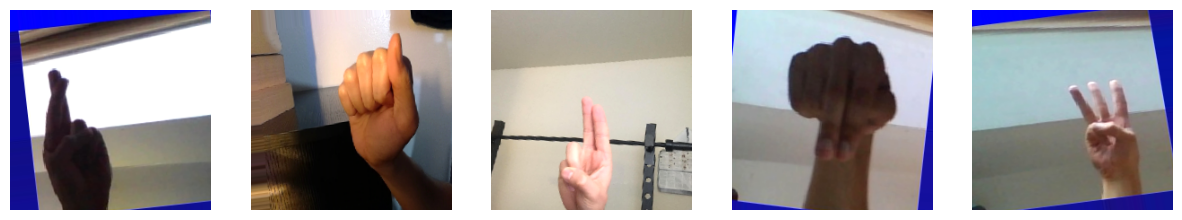

In [36]:
# Define a function to visualize augmented images
def visualize_augmented_images(generator, num_images=5):
    # Generate augmented images
    augmented_images, _ = next(generator)

    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    # Loop through the generated images and display them
    for i in range(num_images):
        # Get an augmented image
        image = augmented_images[i]

        # Denormalize the image (if necessary)
        # For rescale=1.0/255.0, denormalization is not needed

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

# Visualize augmented training images
visualize_augmented_images(train_data, num_images=5)

---

# 3. Modelling - Image Classification

* For this project, due to the lack of time for model training and data collection, we will use transfer learning - the process of taking pretrained models (usually trained on large datasets, such as ImageNet) and then further "fine-tuning" the model with our new dataset.
* We will maintain and use the convolutional layers of the pre-trained model, while leaving out the final output layer and adding on our additional hidden (optional) and output dense layers.


## 3.0 Create Relevant Functions

### Build transfer learning model
Let's create a function to build the transfer learning model.<br>

Following earlier model experiments, the below model parameters were selected for use on all 3 models:
* No of Hidden Layers: `1`
* No of nodes in hidden layer: `64`
* Epochs to train on: `50`
* Batch size: `64`
* Dropout rate: `0.2`
* Learning rate: `0.001`

Originally, only a single output dense layer was added to the pretrained model, however results were poor.<br>
A hidden layer with 64 nodes was then added on, and was able to boost model training score. Dropout, a regularization technique commonly used in deep learning to prevent overfitting, was applied as well (Dropout_rate = 0.2).

In [9]:
def build_trf_model(base_model, activation='softmax', input_shape=(224, 224, 3)):
    # Freeze the base model
    base_model.trainable = False
    
    # Create the transfer learning model
    trf_model = Sequential()
    trf_model.add(base_model)
    
    # Add a dense layer for classification
    trf_model.add(Dense(64, activation='relu'))
    trf_model.add(Dropout(DROPOUT_RATE)) 
    trf_model.add(Dense(26, activation=activation))  
    
    return trf_model

### Create folder to save training logs
After instantiating the transfer learning model and the fully connected layer, let's create a folder for the specific model in order to save the training logs of each epochs for callback to make predictions for evaluation:

In [10]:
def create_checkpoint_callback(folder_name, model):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    checkpoint_filepath = os.path.join(folder_name, 'model.{epoch:02d}.h5')
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath)
    
    return checkpoint_callback

### Plot loss and accuracy
Create a function to plot 2 graphs - loss vs epoch, accuracy vs epoch:

In [11]:
def plot_loss_and_accuracy(history):
    # Plot of loss of train and test
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Plot of test and train accuracy
    train_accuracy = history.history['sparse_categorical_accuracy']
    test_accuracy = history.history['val_sparse_categorical_accuracy']

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot loss vs epoch
    axs[0].plot(train_loss, label='Training loss')
    axs[0].plot(test_loss, label='Testing loss')
    axs[0].set_title('Loss VS Epoch in model training')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot accuracy vs epoch
    axs[1].plot(train_accuracy, label='Train accuracy')
    axs[1].plot(test_accuracy, label='Test accuracy')
    axs[1].set_title('Accuracy VS Epoch in model training')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

### Print Evaluation Metrics
Create a function to print the various evaluation metrics (best train and test score) that we have selected:
* Loss and Accuracy
* Precision, Recall, F1

In [12]:
def print_best_metrics(history):
    # Get the index of the epoch with the best validation loss
    best_epoch = np.argmin(history.history['val_loss'])
    
    # Get the best metrics at the best epoch
    best_train_loss = history.history['loss'][best_epoch]
    best_test_loss = history.history['val_loss'][best_epoch]
    best_train_accuracy = history.history['sparse_categorical_accuracy'][best_epoch]
    best_test_accuracy = history.history['val_sparse_categorical_accuracy'][best_epoch]


    print(f"Best Epoch: {best_epoch + 1}")
    print(f"Train Loss: {best_train_loss:.4f}")
    print(f"Train Accuracy: {best_train_accuracy:.4f}")
    print(f"Validation Loss: {best_test_loss:.4f}")
    print(f"Validation Accuracy: {best_test_accuracy:.4f}")

---

## 3.1 VGG16
**Architecture**: VGG-16 is composed of 16 weight layers, including 13 convolutional layers and 3 fully connected layers. It follows a simple and uniform structure with 3x3 convolutional filters and max-pooling layers. Because of the smaller convolutional filters, it helps to mitigate overfitting to some extent.

**Depth**: VGG-16 is known for its depth, as it has more layers compared to previous models like AlexNet. This depth allows it to learn complex hierarchical features from images, making it effective in tasks like image classification.

<br>

<img src="../images/VGG16_diag.png" alt="drawing" width="400"/>

*VGG16 diagram ([source](https://neurohive.io/en/popular-networks/vgg16/))* <br>

### Setting up the transfer learning model

In [78]:
# Create the transfer learning model with VGG16
pre_trained_model_VGG = VGG16(include_top=False, pooling='avg')

# Build the transfer learning model
trf_model_VGG = build_trf_model(pre_trained_model_VGG)

# Display the summary of the model
trf_model_VGG.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 26)                1690      
                                                                 
Total params: 14,749,210
Trainable params: 34,522
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile and fit the model

In [58]:
# Defining the ModelCheckpoint callback + create folder
checkpoint_callback_VGG = create_checkpoint_callback('VGG16_model', trf_model_VGG)

# Define early stopping callback
early_stopping_VGG = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [59]:
# Compile
opt = Adam(learning_rate=0.001)
trf_model_VGG.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy']) 

In [60]:
# Fit model on training data 
history_VGG = trf_model_VGG.fit(train_data, 
                            validation_data=test_data, 
                            batch_size=BATCH_SIZE,  
                            epochs=EPOCHS,
                            callbacks=[checkpoint_callback_VGG, early_stopping_VGG]
                           )

Epoch 1/50
183/183 [==============================] - 1037s 6s/step - loss: 3.0422 - sparse_categorical_accuracy: 0.1479 - val_loss: 2.7719 - val_sparse_categorical_accuracy: 0.2554
Epoch 2/50
183/183 [==============================] - 1000s 5s/step - loss: 2.4495 - sparse_categorical_accuracy: 0.3160 - val_loss: 2.1975 - val_sparse_categorical_accuracy: 0.4422
Epoch 3/50
183/183 [==============================] - 1003s 5s/step - loss: 2.0093 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.8012 - val_sparse_categorical_accuracy: 0.5623
Epoch 4/50
183/183 [==============================] - 1020s 6s/step - loss: 1.6912 - sparse_categorical_accuracy: 0.5289 - val_loss: 1.5451 - val_sparse_categorical_accuracy: 0.6495
Epoch 5/50
183/183 [==============================] - 1015s 6s/step - loss: 1.4646 - sparse_categorical_accuracy: 0.5933 - val_loss: 1.3665 - val_sparse_categorical_accuracy: 0.6431
Epoch 6/50
183/183 [==============================] - 980s 5s/step - loss: 1.2842 - sparse

Let's save out the model:

In [219]:
pickle.dump(history_VGG, open('history_VGG.pkl', 'wb'))

In [62]:
trf_model_VGG.save('VGG16_model.h5')

### Performance Evaluation Metrics

In [63]:
# Load the saved model
trf_model_VGG = load_model('VGG16_model.h5')

Let's plot loss and accuracy:

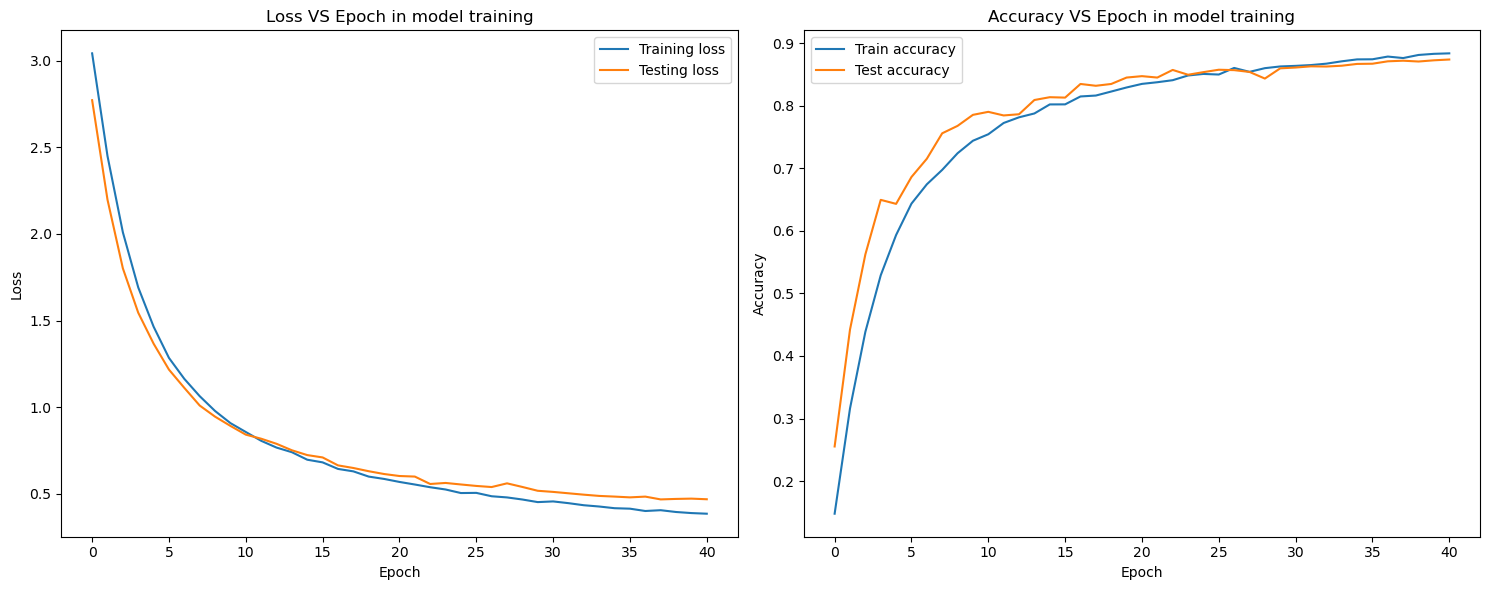

In [64]:
plot_loss_and_accuracy(history_VGG)

In [109]:
print_best_metrics(history_VGG)

Best Epoch: 38
Train Loss: 0.4052
Train Accuracy: 0.8761
Validation Loss: 0.4675
Validation Accuracy: 0.8718


### Model Interpretation and Summary

##### Findings
* The train and test loss and accuracies were showing decent improvements in the first five epochs, showing potential for this model to achieve a decent score.
* The model was slightly underfitted all the way till the 27th epoch, when the training accuracy scores started to outperform testing accuracy scores.
* The optimal epoch was reached on the 38th epoch, where train and test accuracy were 0.8761 and 0.8718 respectively with a balanced fit.
* Training time for each epoch iteration is about 980s, or 5s/step. Training time for this model was significantly longer compared to the rest of the models.

---

## 3.2 InceptionV3
**Architecture of Multiple Branches**: InceptionV3 is characterized by its inception modules, which consist of multiple parallel convolutional branches of different filter sizes. These branches capture features at various scales, allowing the network to learn both fine-grained and high-level features simultaneously.<br>

**Efficient Use of Parameters**: InceptionV3 incorporates 1x1 convolutions, known as bottleneck layers, to reduce the number of parameters and computational complexity while maintaining model expressiveness. This efficient use of parameters enables faster training and inference without sacrificing performance.

<br>

<img src="../images/inceptionv3onc--oview.png" alt="drawing" width="500"/>

*InceptionV3 diagram ([source](https://neurohive.io/en/popular-networks/vgg16/))* <br>

### Setting up the transfer learning model

In [39]:
# Import transfer learning model: GoogLeNet (InceptionV3)
pre_trained_model_INC = InceptionV3(include_top=False, pooling='avg') 

# Build the transfer learning model
trf_model_INC = build_trf_model(pre_trained_model_INC)

trf_model_INC.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 26)                1690      
                                                                 
Total params: 21,935,610
Trainable params: 132,826
Non-trainable params: 21,802,784
_________________________________________________________________


### Compile and fit the model

In [43]:
# Defining the ModelCheckpoint callback + create folder
checkpoint_callback_INC = create_checkpoint_callback('InceptionV3_model', trf_model_INC)

# Define early stopping callback
early_stopping_INC = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [44]:
# Compile
opt = Adam(learning_rate=0.001)
trf_model_INC.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy']) 

In [45]:
# Fit model on training data 
history_INC = trf_model_INC.fit(train_data, 
                            validation_data=test_data, 
                            batch_size=BATCH_SIZE,  
                            epochs=EPOCHS,
                            callbacks=[checkpoint_callback_INC, early_stopping_INC]
                           )

Epoch 1/50
183/183 [==============================] - 392s 2s/step - loss: 2.0838 - sparse_categorical_accuracy: 0.4021 - val_loss: 1.2594 - val_sparse_categorical_accuracy: 0.6796
Epoch 2/50
183/183 [==============================] - 353s 2s/step - loss: 1.1503 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.9062 - val_sparse_categorical_accuracy: 0.7485
Epoch 3/50
183/183 [==============================] - 351s 2s/step - loss: 0.9318 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7914
Epoch 4/50
183/183 [==============================] - 354s 2s/step - loss: 0.8068 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.6891 - val_sparse_categorical_accuracy: 0.7949
Epoch 5/50
183/183 [==============================] - 359s 2s/step - loss: 0.7322 - sparse_categorical_accuracy: 0.7721 - val_loss: 0.6229 - val_sparse_categorical_accuracy: 0.8103
Epoch 6/50
183/183 [==============================] - 355s 2s/step - loss: 0.6520 - sparse_cate

Let's save out the model:

In [219]:
pickle.dump(history_INC, open('history_INC.pkl', 'wb'))

In [48]:
trf_model_INC.save('InceptionV3_model.h5')

### Performance Evaluation Metrics

In [49]:
# Load the saved model
trf_model_INC = load_model('InceptionV3_model.h5')

Let's plot loss and accuracy:

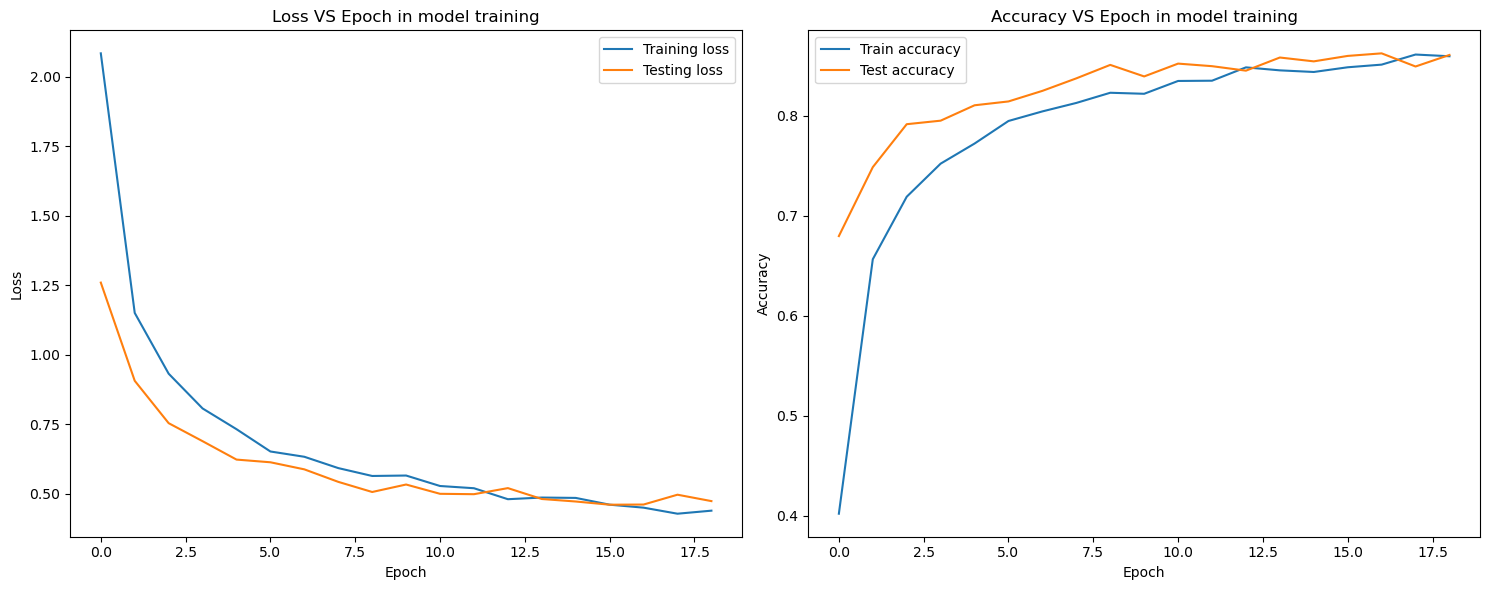

In [50]:
plot_loss_and_accuracy(history_INC)

In [51]:
print_best_metrics(history_INC)

Best Epoch: 16
Train Loss: 0.4607
Train Accuracy: 0.8483
Validation Loss: 0.4606
Validation Accuracy: 0.8597


### Model Interpretation and Summary

##### Findings
* The train and test loss reduced rather significantly in the first 3 epochs, and thereafter, started reducing consistently till the 16th epoch.
* The 16th epoch is hence the optimal epoch where train and test accuracy were 0.8483 and 0.8597 respectively.
* There seems to be potential for the model's accuracy score to continue increasing, if we set the patience higher.
* Training time for each epoch iteration is about 365s, or 2s/step.
* The model produce satisfactory results with just slight underfitting.

---

## 3.3 MobileNetV2
**Depthwise Separable Convolution**: MobileNetV2 utilizes depthwise separable convolutions as its primary building block. This technique separates standard convolutions into two stages: depthwise convolutions, which process each input channel separately, and pointwise convolutions, which combine information from depthwise layers. This reduces computational complexity and model size while maintaining strong feature representation.<br>

**Efficiency and Speed**: MobileNetV2 is engineered for efficient deployment on mobile devices, IoT devices, and edge computing platforms. Its architecture is optimized to reduce both memory usage and inference time, making it suitable for our problem statement

<br>

<img src="../images/MobileNetv2.png" alt="drawing" width="500"/>

*MobileNetV2 diagram ([source](https://www.researchgate.net/figure/The-proposed-MobileNetV2-network-architecture_fig1_350152088))* <br>

### Setting up the transfer learning model

Import transfer learning model and freeze model, using our earlier defined function:

In [30]:
# Import transfer learning model: MobileNetV2
pre_trained_model_MN = MobileNetV2(include_top=False, pooling='avg') 

# Build the transfer learning model
trf_model_MN = build_trf_model(pre_trained_model_MN)

trf_model_MN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 26)                1690      
                                                                 
Total params: 2,341,658
Trainable params: 83,674
Non-trainable params: 2,257,984
_________________________________________________________________


### Compile and fit the model

In [31]:
# Defining the ModelCheckpoint callback + create folder
checkpoint_callback_MN = create_checkpoint_callback('MobileNetV2_model', trf_model_MN)

# Define early stopping callback
early_stopping_MN = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [32]:
# Compile
opt = Adam(learning_rate=0.001)
trf_model_MN.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy']) 

In [33]:
# Fit the model
history = trf_model_MN.fit(train_data, 
                            validation_data=test_data, 
                            batch_size=BATCH_SIZE,  
                            epochs=EPOCHS,
                            callbacks=[checkpoint_callback_MN, early_stopping_MN]
                           )

Epoch 1/50
183/183 [==============================] - 329s 2s/step - loss: 1.6816 - sparse_categorical_accuracy: 0.5341 - val_loss: 0.8538 - val_sparse_categorical_accuracy: 0.7872
Epoch 2/50
183/183 [==============================] - 306s 2s/step - loss: 0.7628 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.5824 - val_sparse_categorical_accuracy: 0.8440
Epoch 3/50
183/183 [==============================] - 302s 2s/step - loss: 0.5713 - sparse_categorical_accuracy: 0.8367 - val_loss: 0.4819 - val_sparse_categorical_accuracy: 0.8606
Epoch 4/50
183/183 [==============================] - 363s 2s/step - loss: 0.4679 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.4321 - val_sparse_categorical_accuracy: 0.8741
Epoch 5/50
183/183 [==============================] - 382s 2s/step - loss: 0.3979 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.3750 - val_sparse_categorical_accuracy: 0.8888
Epoch 6/50
183/183 [==============================] - 331s 2s/step - loss: 0.3507 - sparse_cate

Let's save out the model and history:

In [219]:
pickle.dump(history, open('history_MN.pkl', 'wb'))

In [46]:
trf_model_MN.save('MobileNetV2_model.h5')

### Performance Evaluation Metrics

Let's plot loss and accuracy:

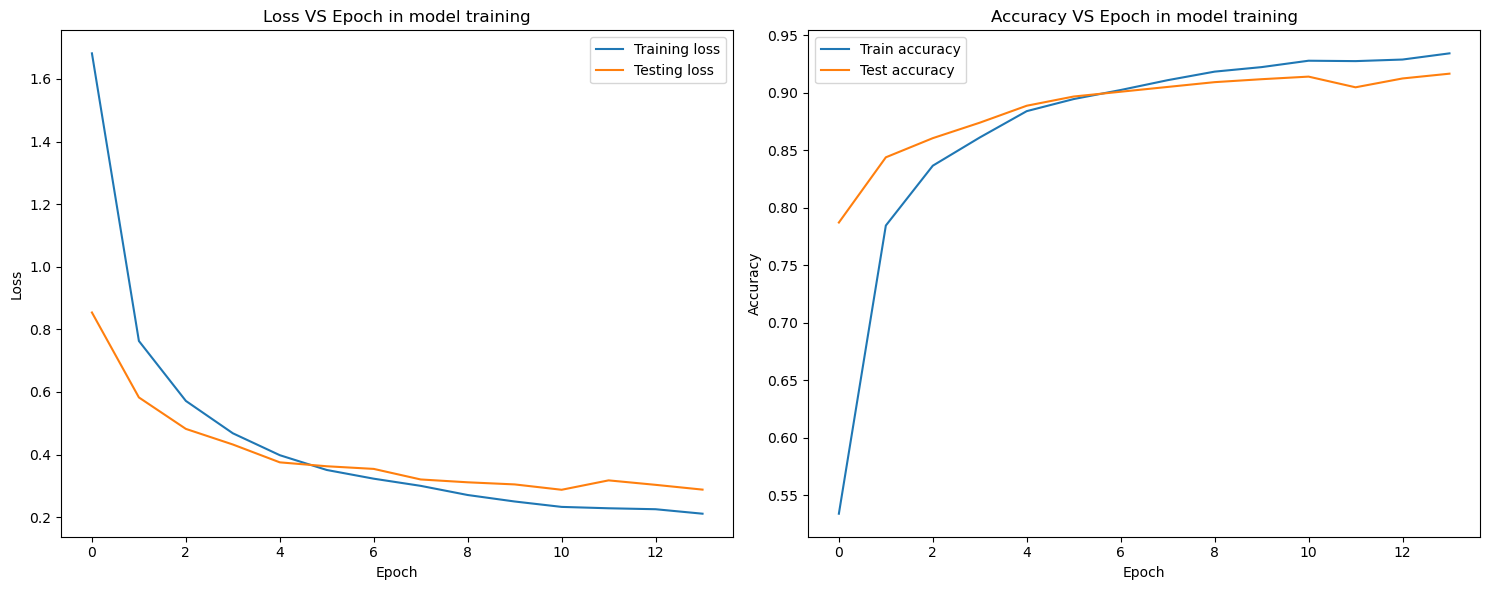

In [35]:
plot_loss_and_accuracy(history)

In [47]:
print_best_metrics(history)

Best Epoch: 11
Train Loss: 0.2327
Train Accuracy: 0.9280
Validation Loss: 0.2874
Validation Accuracy: 0.9141


### Model Interpretation and Summary

##### Findings
* The train and test loss reduced rather significantly in the first 5 epochs, and thereafter, started reducing consistently till the 11th epoch.
* The 11th epoch is hence the optimal epoch where train and test accuracy were 0.9827 and 0.9141 respectively.
* The model was slightly underfitted all the way till the 7th epoch, when the training accuracy scores started to outperform testing accuracy scores.
* Training time for each epoch iteration varies between a range of 300-382s, or 2s/step.
* The model produce satisfactory results with just slight overfitting.

---

## 3.4 EfficientNetB0
EfficientNetB0 is the base model in the EfficientNet family of deep neural network architectures.<br>

**Efficiency through Compound Scaling**: EfficientNetB0 is designed with a concept known as "compound scaling." This approach balances the network's depth, width, and resolution to maximize efficiency while maintaining strong performance. It achieves this by scaling the architecture in a principled manner, ensuring that all components work together efficiently.<br>


<img src="../images/EfficientNetB0.png" alt="drawing" width="300"/>

*EfficientNetB0 diagram ([source](https://www.researchgate.net/figure/The-EfficientNetB0-network-architecture_fig8_346296594))* <br>

### Setting up the transfer learning model

In [67]:
# Import the EfficientNet model
from efficientnet.tfkeras import EfficientNetB0

In [74]:
# Create the transfer learning model with VGG16
pre_trained_model_EffNet = EfficientNetB0(include_top=False, pooling='avg')

# Build the transfer learning model
trf_model_EffNet = build_trf_model(pre_trained_model_EffNet)

# Display the summary of the model
trf_model_EffNet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 64)                81984     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 26)                1690      
                                                                 
Total params: 4,133,238
Trainable params: 83,674
Non-trainable params: 4,049,564
_________________________________________________________________


### Compile and fit the model

In [75]:
# Defining the ModelCheckpoint callback + create folder
checkpoint_callback_EffNet = create_checkpoint_callback('EfficientNetB0_model', trf_model_EffNet)

# Define early stopping callback
early_stopping_EffNet = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [76]:
# Compile
opt = Adam(learning_rate=0.001)
trf_model_EffNet.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy']) 

In [77]:
# Fit model on training data 
history_EffNet = trf_model_EffNet.fit(train_data, 
                            validation_data=test_data, 
                            batch_size=BATCH_SIZE,  
                            epochs=EPOCHS,
                            callbacks=[checkpoint_callback_EffNet, early_stopping_EffNet]
                           )

Epoch 1/50
183/183 [==============================] - 622s 3s/step - loss: 1.6013 - sparse_categorical_accuracy: 0.5770 - val_loss: 0.7752 - val_sparse_categorical_accuracy: 0.8283
Epoch 2/50
183/183 [==============================] - 523s 3s/step - loss: 0.6736 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.5371 - val_sparse_categorical_accuracy: 0.8616
Epoch 3/50
183/183 [==============================] - 523s 3s/step - loss: 0.4846 - sparse_categorical_accuracy: 0.8672 - val_loss: 0.4398 - val_sparse_categorical_accuracy: 0.8843
Epoch 4/50
183/183 [==============================] - 525s 3s/step - loss: 0.3950 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.3710 - val_sparse_categorical_accuracy: 0.8991
Epoch 5/50
183/183 [==============================] - 556s 3s/step - loss: 0.3301 - sparse_categorical_accuracy: 0.9073 - val_loss: 0.3596 - val_sparse_categorical_accuracy: 0.8923
Epoch 6/50
183/183 [==============================] - 633s 3s/step - loss: 0.2917 - sparse_cate

Let's save out the model:

In [219]:
pickle.dump(history_EffNet, open('history_EffNet.pkl', 'wb'))

In [83]:
trf_model_EffNet.save('EfficientNetB0_model.h5')

### Performance Evaluation Metrics

In [82]:
# step 2: Load the saved model
trf_model_EffNet = load_model('EfficientNetB0_model.h5')

Let's plot loss and accuracy:

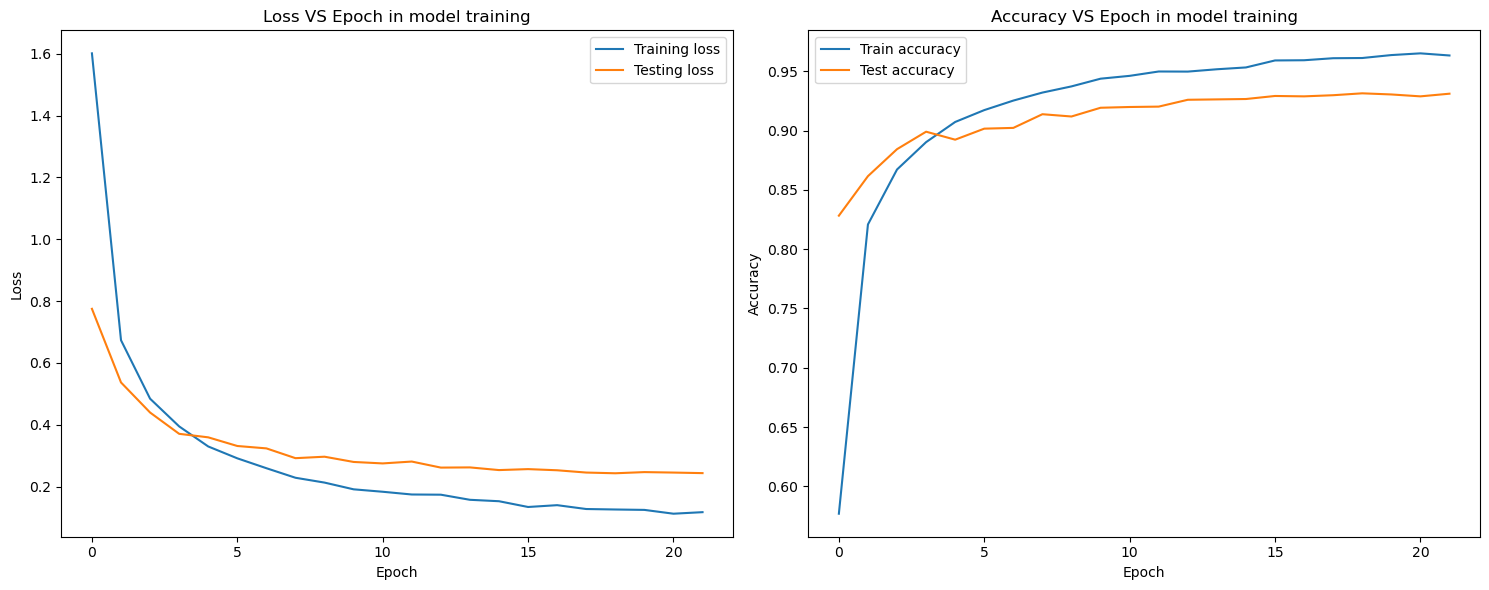

In [80]:
plot_loss_and_accuracy(history_EffNet)

In [110]:
print_best_metrics(history_EffNet)

Best Epoch: 19
Train Loss: 0.1263
Train Accuracy: 0.9612
Validation Loss: 0.2434
Validation Accuracy: 0.9314


### Model Interpretation and Summary

##### Findings
* The train and test loss reduced rather significantly in the first 3 epochs, and thereafter, started reducing consistently till the 19th epoch.</mark>
* The 19th epoch is hence the optimal epoch where train and test accuracy were 0.9612 and 0.9314 respectively.
* The model was slightly underfitted all the way till the 5th epoch, when the training accuracy scores started to outperform testing accuracy scores.
* Training time for each epoch iteration varies between a range of 466-662s, or 3s/step.
* The model produces great results with just slight overfitting.

---

# 4. Best Model Selection


|Model No|Model Used|Loss|Accuracy|Conclusion|
|--|--|--|--|--|
|1|VGG-16|0.4052 (Train)<br> 0.4675 (Test)|0.8761 (Train)<br> 0.8718 (Test)|Good fit|
|2|InceptionV3|0.4607 (Train)<br>0.4606 (Test)|0.8483 (Train)<br> 0.8597 (Test)|Slight underfitting|
|3|MobileNetV2|0.2327 (Train)<br> 0.2874 (Test)|0.9280 (Train)<br> 0.9141 (Test)|Slight overfitting|
|4|**EfficientNetB0**|0.1263 (Train)<br> 0.2434 (Test)|0.9612 (Train)<br> 0.9314 (Test)|Very slight overfitting <br>Best score|


<br>

* We tried various transfer learning models - since the aim of the model is to be able to successfully do image classification of hand-signed alphabets, we select the model with the highest accuracy score, with the lowest cross-entropy loss.

* The EfficientNetB0 model is hence our best model - it has a reasonable average training time per epoch of around 500seconds, yet has the best train and test scores of 96.1% and 93.1% respectively. It also has the lowest loss amongst the models at 0.2434 testing loss.Since we are using the B0 version of EfficientNet, there is still potential for the model scores to be further improved, albeit at the expense of computational power and time required. However, for the context of the problem we are solving, i.e. sign language alphabet classification, a test accuracy score of 93.1% is more than satisfactory.

---

# 5. Model Interpretation

## 5.1 Make predictions using Best Model

#### Try out on a test image
The test image shows a personally self-taken hand sign for alphabet "C"<br>
<img src="../images/test1.jpg" alt="drawing" width="300"/>


In [51]:
# Load the model using custom_objects
model = load_model('EfficientNetB0_model.h5')

In [52]:
# Define the rescaling factor (typically 1.0/255 for RGB images)
rescale_factor = 1.0 / 255.0

# Create an ImageDataGenerator with only rescaling for test data
test_data_generator = ImageDataGenerator(rescale=rescale_factor)

# Step 3: Load an image for prediction into Python
img = image.load_img('../images/test1.jpg', target_size=(224, 224))  
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

# Apply rescaling to the test image
img = test_data_generator.standardize(img)

# Step 4: Make predictions
predictions = model.predict(img)[0]  

# Step 5: Interpret the predictions using class names
class_names = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

# Get the class names sorted by predicted probabilities
class_probs = [(class_name, class_prob) for class_name, class_prob in class_names.items()]
class_probs.sort(key=lambda x: predictions[x[1]], reverse=True)

# Print the top 3 predicted classes and their probabilities
top_n = 3
for i in range(top_n):
    class_name, class_prob = class_probs[i]
    print(f"Top {i+1} Prediction: {class_name}, Probability: {predictions[class_prob]:.4f}")

1/1 [==============================] - 1s 837ms/step
Top 1 Prediction: C, Probability: 0.7620
Top 2 Prediction: P, Probability: 0.1418
Top 3 Prediction: Q, Probability: 0.0736


##### Findings
* Using our best model, the EfficientNetB0, the model was able to predict the test image accurately to a rate of 76%.
* Compared to our train and test dataset, this image has a busier background but the model was still effective in identifying the alphabet that was signed.